# Решающее дерево

Лабораторная работа № 5 Минеева Анна Вяткина Арина

Отметим, что решающее дерево состоит из вершин, в которых записывает некоторое условие, а в листах дерева - прогноз. Условия во внутренних вершинах выбираются простыми. Наиболее частый вариант - проверка лежит ли значение некоторого признака $x^j$ левее порога $t$:

$[x^j \leq t]$

Легко заметить, что такое условие зависит только от одного признака. Прогноз в листе является вещественным числом, если решается задача регрессии. Если же решается задача классификации, то в качестве прогноза выступает или класс или распределение вероятностей классов.

Запишем некоторую функцию ошибки следующим образом: есть набор данных $X_m$, есть номер рассматриваемого признака $j$ и есть порог $t$.

$L(X_m, j, t) \rightarrow \underset{j,t}{min}$

Осуществим перебор всех возможных признаков $j$ и порогов $t$ для этих признаков. Каждый раз исходное множество будет разбиваться на два подмножества:

$X_l = \{x \in X_m | [ x^j \leq t ] \}$ и $X_к = \{x \in X_m | [ x^j > t ] \}$

Такую процедуру можно продолжить для каждого получившегося множества (рекурсивно вызывать функцию деления для получающихся подмножеств).

Необходимо отметить, что если вершина была объявлена листом, необходимо сделать прогноз для этого листа. Для задачи регрессии берется среднее значение по этой выборке,
для задачи классификации возвращается тот класс, которые наиболее популярен в выборке. Можно указывать вероятность классов в листе.

Для каждого разбиения необходимо расчитывать функцию потерь:

$L(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r)$,

где $H(X)=\sum\limits_{k=1}^{K} p_k(1 - p_k)$ - критерий информативности Джинни.

$p_k$ - доля объектов класса $k$ в выборке X:

$p_k=\frac{1}{|X|}\sum\limits_{i \in X}{[y_i = k]}$

В задаче работаем только с числовыми данными и строим дерево классификации.

Данные сгенерированы случайным образом.

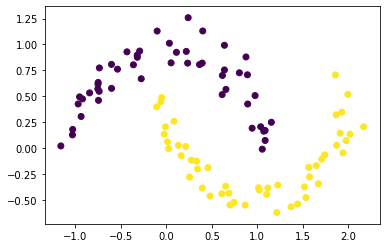

In [1]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x, y = make_moons(n_samples=100, noise=0.1)
plt.scatter(x[:,0], x[:,1], c = y)


## Задание

Напишите класс дерева, который реализует метод train, которая получает на вход матрицу данных ($x$) и целевые переменные ($y$), на выходе функция возвращает дерево в виде словаря в каждом случае записывается номер признака ($i$), порог разбиения($t$), значение в листовой вершине слева ($y_l$) и значение в листовой вершине справа ($y_r$). Вместо занчения в листовой вершине может содержаться следующий словарь с теми же ключами и так далее.

Необходимо учесть:

1. Возможность строить дерево строго определенной глубины и возможность указать максимальное количество объектов в листовой вершине.
2. Пороги разбиения должны лежать строго по середине между ближайшими обектами.
3. Разбиений не требуется, если в получившемся множестве находятся объекты одного класса.
4. Количество различных классов объектов в целевой переменной может быть больше двух.


In [10]:
class Tree:
    def __init__(self, depth=5, max_num_leaf=3):
        self.depth = depth
        self.max_num_leaf = max_num_leaf
        self.tree = {}
        
    def train(self, x, y):
        self.tree = self.split(x, y, self.depth)
    
    def split(self, x, y, depth):
        tree = {}
        loss_now = np.Inf # даём начальное значение равное бесконечности 
        for it in range(x.shape[1]): # shape[1] - количество стольцов
            sort = np.sort(x[:,it]) # сортируем по 1 столбцу от меньшего к большему 
            porog_t = [(sort[i] + sort[i+1]) / 2 for i in range(len(sort) - 1)] 
            # считаем среднее двух элементов (0го и 1го, 1го и 2го, ...), формируем из этих значений list
            # это наши пороги разбиения 
            for t in porog_t: # проходимся по полученным значениям 
                l = self.loss(x, y, it, t) # считаем функцию потерь 
                if loss_now > l: # сравнием текущее значение потери с полученным
                    loss_now = l # если текущее значение больше полученного, то в текущее кладём полученное 
                    # чтобы в текущем значении у нас находилось самое минимальное 
                    tree['priznak'] = it # в словарь под ключ 'priznak' скалыдваем номер столбца
                    tree['porog_t'] = t # под ключ 'porog_t' добавляет порог разбиения 
                    
        x_l = x[x[:, tree['priznak']] < tree['porog_t']] 
        # x_l - значения x, если значений в priznak меньше, чем значений в porog_t
        y_l = y[x[:, tree['priznak']] < tree['porog_t']] 
        # y_l - значения y, если значений в priznak меньше, чем значений в porog_t
        x_r = x[x[:, tree['priznak']] >= tree['porog_t']]
        # x_r - значения x, если значений в priznak больше или равно, чем значений в porog_t
        y_r = y[x[:, tree['priznak']] >= tree['porog_t']]
        # y_r - значения y, если значений в priznak больше или равно, чем значений в porog_t
        depth = depth - 1 # уменьшаем глубину
        
        class_l = set(y_l) # добавляем y_l, не содержит дубликатов
        class_r = set(y_r) # добавляем y_r, не содержит дубликатов

        if len(class_l) == 1: # если получился чистый класс 
            tree['left'] = y_l[0] # под ключ 'left' добавляем значение метки этого чистого класса 
        elif (depth == 0 or len(y_l) < self.max_num_leaf): 
            # иначе, если глубина равна 0 и длина y_l меньше максимального количества листков
            left = 0 
            n = 0
            for cl in class_l: # проходимся по значениям класса 
                if (len(y_l[y_l == cl]) > n):  # y_l[y_l == cl] - сколько меток одного класса 
                    n = len(y_l[y_l == cl])  # находим максимальное число меток одного класса 
                    left = cl # в left добавляем значение метки (0 или 1)
            tree['left'] = left # под ключ left добавляем значение метки 
        else: tree['left'] = Tree.split(self, x_l, y_l, depth) # иначе делим дальше (в зависимости от глубины дерева)
        if len(class_r) == 1: # повторяем всё тоже самое для правого класса 
            tree['right'] = y_r[0]
        elif (depth == 0 or len(y_r) < self.max_num_leaf):
            right = 0
            n = 0
            for cl in class_r:
                if (len(y_r[y_r == cl]) > n):
                    n = len(y_r[y_r == cl])
                    right = cl
            tree['right'] = right
        else: tree['right'] = Tree.split(self, x_r, y_r, depth)
        return tree # возвращаем наш словарь 

    def predict(self, x, tree):
        y = 0 
        if x[tree['priznak']] < tree['porog_t']:
            if str(tree['left']).isdigit()==1: # если левый край - метка 1
                y = tree['left'] # y = 1
            else:
                y = self.predict(x, tree['left'])   # рекурсия
        else: 
            if str(tree['right']).isdigit()==1: # если правый край - метка 1
                y = tree['right'] # - y = 1
            else:
                y = self.predict(x, tree['right']) # рекурсия 
        return y

    
    def loss(self, x, y, i, t): # функция потерь
        x_l = x[x[:,i] < t]
        y_l = y[x[:,i] < t]
        x_r = x[x[:,i] >= t]
        y_r = y[x[:,i] >= t]
        return len(x_l) / len(x) * self.gini(x_l, y_l) + len(x_r) / len(x) * self.gini(x_r, y_r)

    def gini(self, x, y): # коэффициент Джинни 
        p0 = len(y[y == 0]) / len(y)
        p1 = len(y[y == 1]) / len(y)
        return p0*(1-p0) + p1*(1-p1)

In [11]:
clf = Tree(depth=2, max_num_leaf=1)
clf.train(x, y)
tree = clf.tree
tree

{'priznak': 1,
 'porog_t': -0.137279176853409,
 'left': {'priznak': 0,
  'porog_t': -0.47209737437798394,
  'left': 0,
  'right': 1},
 'right': {'priznak': 0,
  'porog_t': 0.26805418959273974,
  'left': 0,
  'right': 1}}

Постройте решающее дерево с глубиной 1, 2 и 3.

Визуализируйте получившиеся результаты классификатора на плоскости. Для этого воспользуйтесь кодом ниже, чтобы построить поверхность. $t$ - порог разбиения $i$ - номер признака.

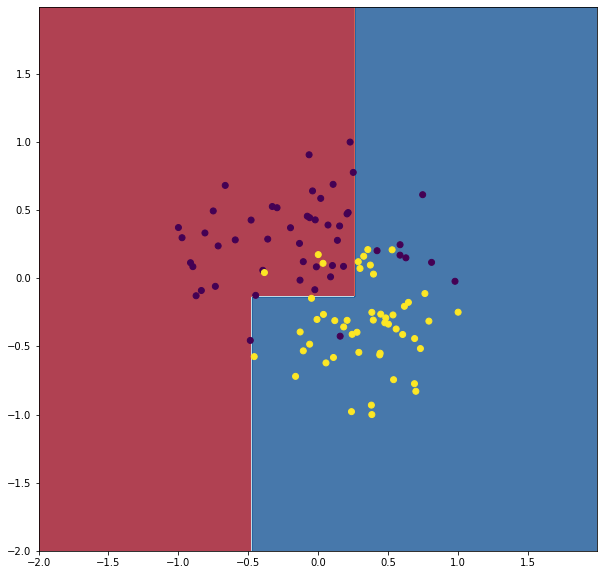

In [12]:
def tree_clf(x):
    y_pred = list()  
    for it in x.transpose():
        y_pred.append(clf.predict(it, tree))   
    return np.array(y_pred)


h = .01
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.figure(figsize=(10,10))
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)


Постройте дерево максимальной глубины для своих случайных данных.

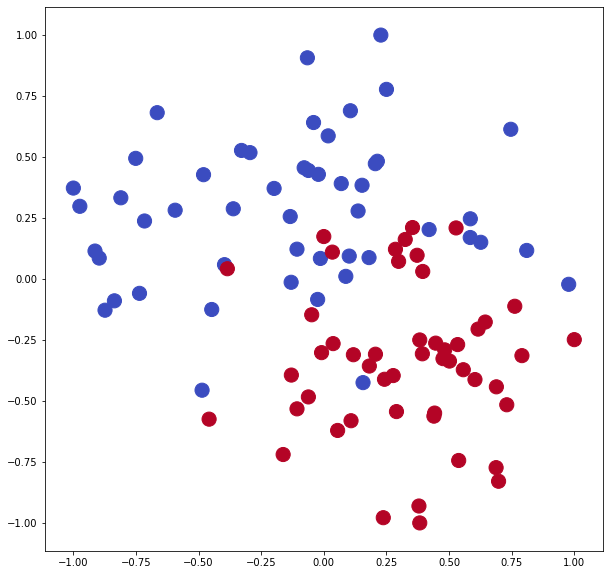

In [5]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2 ,cluster_std=1, random_state=18, center_box=(-3, 3))
cmap = plt.cm.coolwarm
plt.figure(figsize=(10,10))
x[:,0] = 2 * (x[:,0] - x[:,0].min()) / (x[:,0].max() - x[:,0].min()) - 1
x[:,1] = 2 * (x[:,1] - x[:,1].min()) / (x[:,1].max() - x[:,1].min()) -1 
plt.scatter(x[:,0], x[:,1], s = 200, c = y, cmap=cmap)

In [13]:
clf = Tree(depth=900, max_num_leaf=1)
clf.train(x, y)
tree = clf.tree
tree

{'priznak': 1,
 'porog_t': -0.137279176853409,
 'left': {'priznak': 0,
  'porog_t': -0.47209737437798394,
  'left': 0,
  'right': {'priznak': 0,
   'porog_t': 0.16913416397294256,
   'left': {'priznak': 0,
    'porog_t': 0.13728950397522233,
    'left': 1,
    'right': 0},
   'right': 1}},
 'right': {'priznak': 0,
  'porog_t': 0.26805418959273974,
  'left': {'priznak': 1,
   'porog_t': 0.2059447703864683,
   'left': {'priznak': 1,
    'porog_t': 0.14818645281738096,
    'left': {'priznak': 0,
     'porog_t': -0.3908286962307593,
     'left': 0,
     'right': {'priznak': 0,
      'porog_t': -0.25782491234770794,
      'left': 1,
      'right': {'priznak': 1,
       'porog_t': 0.10206816064220792,
       'left': 0,
       'right': {'priznak': 0,
        'porog_t': -0.03652808247516748,
        'left': 0,
        'right': 1}}}},
    'right': 1},
   'right': 0},
  'right': {'priznak': 0,
   'porog_t': 0.4076373460894732,
   'left': 1,
   'right': {'priznak': 1,
    'porog_t': -0.0667662038

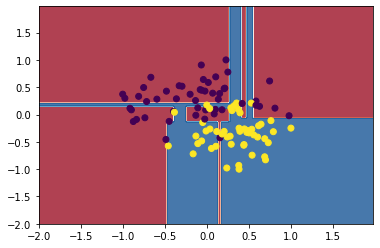

In [14]:
def tree_clf(x):
    y_pred = list()  
    for it in x.transpose():
        y_pred.append(clf.predict(it, tree))   
    return np.array(y_pred)


h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)